In [143]:
import sys
sys.path.append("/end/home/rh2310/TINN/turing_codebase")
import copy
from multiprocessing import Pool
#from solvers.explicit_Euler import integrate
from solvers.explicit_Adams_Bashforth import integrate
from solvers.turing_models import Brusselator, FitzHugh_Nagumo, Schnakenberg, Koch_Meinhardt 

In [206]:
import logging
logger = logging.getLogger('simulation')
hdlr = logging.FileHandler('simulation.log')
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)
logger.setLevel(logging.ERROR)

In [162]:
from collections import namedtuple

def Brusselator_steady_state(A, B):
    return (A, B/A)

Simulation = namedtuple(
    "Simulation", 
    ["name",
     "n", "L", "Ds", 
     "dt", "t_start", "t_end", "t_steps", 
     "parameters",
     "steady_state_func",
     "perturbation_size",
     "kinetic_func",
     "sample_parameters",
     "sample_parameters_num",
     "sample_parameters_std"],
     defaults=["Brusselator",
              (128, 128), (1,1), (.02, .4),
              0.002, 0, 2, 64,
              {"A":2, "B":3},
              Brusselator_steady_state,
              0.1,
              Brusselator,
              True,
              30,
              (.5, .5)]
)

def new_from(o, **kwargs):
    old = o._asdict()
    p = {**old, **kwargs}
    return Simulation(**p)
    
    

In [163]:
def run_simulation(simulation, c0 = None):
    if c0 is None:
        # perturbed initial condition
        c0 = np.random.normal(scale=simulation.perturbation_size, 
                              size=(2, simulation.n[0], simulation.n[1]))
    
        # steady state
        ss = simulation.steady_state_func(**simulation.parameters)
        c0[0, :, :] += ss[0]
        c0[1, :, :] += ss[1]
        
    # Note that the order of value in f_args must be ordered 
    # alphabetically correspond to the name of the parameters
    f_args = tuple(simulation.parameters.values())    
    t = np.linspace(simulation.t_start, simulation.t_end, simulation.t_steps)
    sol = integrate(c0, 
                    t, 
                    simulation.dt, 
                    simulation.n, 
                    simulation.L, 
                    simulation.Ds, 
                    simulation.kinetic_func, 
                    f_args)
    return sol
    

In [199]:
MAX_DT_RETRY = 5
MAX_CONTINUED_RETRY = 4

def continued_simulation(simulation_pre, solution_pre, retry = 1):    
    while retry < MAX_CONTINUED_RETRY:
        simulation = new_from(simulation_pre,
                              t_start = simulation_pre.t_end,
                              t_end = 2*simulation_pre.t_end - simulation_pre.t_start)
         
        solution = run_simulation(simulation, c0=solution_pre[...,-1])
        simulation = new_from(simulation,
                              t_start = simulation_pre.t_start) 
        
        solution = np.concatenate([solution_pre, solution], axis=3)
        
        if np.max(np.abs(solution[..., -2]-solution[..., -1])) > 1e-3:
            return continued_simulation(simulation, solution, retry+1)
        else:
            simulation = new_from(simulation,
                              t_steps = simulation.t_steps * (retry+1))
            return simulation, solution, "Successful", ""

    simulation = new_from(simulation_pre,
                          t_steps = simulation_pre.t_steps * retry)
    return simulation, solution_pre, "Failed - continued", ""

def run_simulation_policy(simulation):        
    try :
        
        retry = 0    
        while retry < MAX_DT_RETRY:        
            solution = run_simulation(simulation)        

            if np.any(np.isnan(solution)):
                simulation = new_from(simulation, dt = simulation.dt/2)
            elif np.max(np.abs(solution[..., -2]-solution[..., -1])) > 1e-3:            
                return continued_simulation(simulation, solution)                
            else:
                return simulation, solution, "Successful", ""

            retry += 1

        return simulation, None, "Failed - dt", ""
    except Exception as e:
        logger.error('Failed to run simulation: '+ str(e))
        return None, None, "Failed - Error", e

In [280]:


import pathlib
    
def save_simulation(simulation, sol, res, exceptions):
    try:
        
        path = pathlib.PurePath(OUT_ROOT)        
        path = path.joinpath(simulation.name)        
        if pathlib.Path(path).exists() == False:
            pathlib.Path(path).mkdir(parents = False, exist_ok = False)
            
        if simulation is not None:
            with open(path.joinpath("simulation.txt"), 'w') as f:
                sim2 = new_from(Simulation(),
                                steady_state_func = None,
                                kinetic_func = None)
                f.write(str(sim2))
        if sol is not None:
            with open(path.joinpath(f"{simulation.name}.npy"), 'wb') as f:
                np.save(f, sol)
            
        with open(path.joinpath("result.txt"), 'w') as f:
            f.write(res)
        
    except Exception as e:
        logger.error('Failed to save the reurlt: '+ str(e))
        print('Failed to save the reurlt: '+ str(e))

In [201]:
simulation, sol, res,exceptions = run_simulation_policy(Simulation())
res

'Failed - continued'

In [227]:
a =  new_from(Simulation(),
     steady_state_func = None,
     kinetic_func = None)
eval(str(a))

Simulation(name='Brusselator', n=(128, 128), L=(1, 1), Ds=(0.02, 0.4), dt=0.002, t_start=0, t_end=2, t_steps=64, parameters={'A': 2, 'B': 3}, steady_state_func=None, perturbation_size=0.1, kinetic_func=None, sample_parameters=True, sample_parameters_num=30, sample_parameters_std=(0.5, 0.5))

In [239]:
import os

In [244]:
os.path.abspath(".")

'/end/home/rh2310/morpho_repo'

In [274]:
data_path = os.path.abspath("./test/Brusselator_1_11/Brusselator_1_11.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)

In [275]:
data.shape

(2, 128, 128, 64)

In [266]:
simulations_list = [
    Simulation(name="Brusselator_1", Ds=(0.02, 0.4)),
    Simulation(name="Brusselator_2", Ds=(0.01, 0.4)),
]

In [268]:
def sample_parameters_for_simulation_policy(simulations):
    
    for simulation in simulations:
        if simulation.sample_parameters == False:
            yield simulation
        else:
            for sample_num in range(simulation.sample_parameters_num+1):
                # The original data point
                if sample_num == 0:
                    yield simulation
                else:
                    # Note that the order of value in f_args must be ordered 
                    # alphabetically correspond to the name of the parameters
                    parameters = list(simulation.parameters.items())

                    sampled_parameters = np.random.normal(loc = list(map(lambda item: item[1], parameters)),
                                                      scale = simulation.sample_parameters_std,
                                                      size=len(parameters))

                    simulation_i = new_from(simulation,
                                            name = simulation.name + f"_{sample_num}",
                                            parameters = dict(map(lambda item: (item[0][0], item[1]), 
                                                                  zip(parameters,sampled_parameters))))

                    yield simulation_i


In [281]:
OUT_ROOT = '/end/home/rh2310/morpho_repo/test/'

def run_and_save_simulation(simulation):
    path = pathlib.PurePath(OUT_ROOT)
    if pathlib.Path(path).exists() == False:
        raise FileNotFoundError(f"OUR_ROOT:'{OUT_ROOT}' was not found.")
        
    simulation, sol, res,exceptions = run_simulation_policy(simulation)
    save_simulation(simulation, sol, res,exceptions)
    return res,exceptions


with Pool() as pool:
    res = pool.map(run_and_save_simulation, 
                   list(sample_parameters_for_simulation_policy(simulations_list)))

In [272]:
res = np.array(res)

In [273]:
logger.info

array([['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Successful', ''],
       ['Successful', ''],
       ['Successful', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Successful', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Successful', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Failed - continued', ''],
       ['Failed - continu

In [263]:
def Koch_Meinhardt(c, t, f_args):
    kappa_u, mu_u, rho_u, rho_v, sigma_u, sigma_v = f_args
    u = c[0, :, :]
    v = c[1, :, :]
    u2 = u**2
    u2v = u2 * v
    u2v_u2 = u2v / (1.0 + kappa_u * u2)
    fu = rho_u * u2v_u2 - mu_u * u + sigma_u
    fv = -rho_v * u2v_u2 + sigma_v
    return np.stack((fu, fv))

def Koch_Meinhardt_steady_state(kappa_u, mu_u, rho_u, rho_v, sigma_u, sigma_v):
    u_s = (rho_u * sigma_v)/(rho_v * mu_u) + (sigma_u / mu_u)
    v_s = ((1 + kappa_u * u_s**2)/u_s**2)*(sigma_v / rho_v)
    return (u_s, v_s)

    

In [264]:
c0 = np.zeros((2,10,10))

u_s, v_s = Koch_Meinhardt_steady_state(kappa_u=.25, mu_u=1, rho_u=2, rho_v=2, sigma_u=1, sigma_v=.5)
c0[0, :, :] = u_s
c0[1, :, :] = v_s

Koch_Meinhardt(c0, 0, (0.25, 1, 2, 2, 1, .5))

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

In [67]:
from matplotlib import pyplot as plt

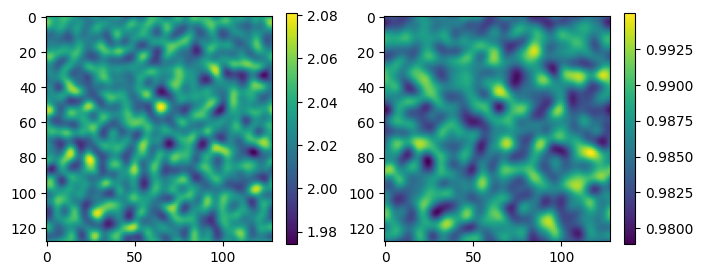

In [276]:
index = -1
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow( data[0,:,:, index])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, index])
plt.colorbar(shrink=.75)
plt.show()

In [279]:
np.max(np.abs(data[0,:,:, -1]-data[0,:,:, -2]))

0.0006184287473813832